<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/EVA4P2_S8_SRGAN_V3_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! nvidia-smi

Tue Mar 16 10:43:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 32kB/s 
     |████████████████████████████████| 6.5MB 35.5MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.5.1+cu92 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101


In [6]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
import seaborn as sns
sns.set()
!pip install torchsummary
from torchsummary import summary
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu92


In [7]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2
%cd '/content/Deep_Learning_EVA4_Phase2/S8_SRGAN_Neural Transfer'
! ls

Cloning into 'Deep_Learning_EVA4_Phase2'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 1415 (delta 17), reused 0 (delta 0), pack-reused 1376
Receiving objects: 100% (1415/1415), 180.89 MiB | 24.99 MiB/s, done.
Resolving deltas: 100% (755/755), done.
Checking out files: 100% (233/233), done.
/content/Deep_Learning_EVA4_Phase2/S8_SRGAN_Neural Transfer
data_utils.py			    EVA4P2_S8_SRGAN_V2.ipynb  pytorch_ssim
EVA4P2_S8_Neural_Transfer_V2.ipynb  loss.py		      README.md
EVA4P2_S8_SRGAN_V1.ipynb	    model.py		      train.py


In [8]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S8_SRGAN_Neural Transfer/')
import pytorch_ssim
from data_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
import torchvision.utils as utils
from loss import GeneratorLoss
from model import Generator, Discriminator

In [7]:
CROP_SIZE      = 44
UPSCALE_FACTOR = 4
NUM_EPOCHS     = 1000

In [8]:
train_set    = TrainDatasetFromFolder('/content/gdrive/My Drive/EVA4P2_S8_Data/train_data', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set      = ValDatasetFromFolder('/content/gdrive/My Drive/EVA4P2_S8_Data/valid_data', upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=64, shuffle=True)
val_loader   = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)

In [9]:
netG = Generator(UPSCALE_FACTOR)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator()
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

# generator parameters: 734219
# discriminator parameters: 5215425


In [10]:
generator_criterion = GeneratorLoss()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [11]:
if torch.cuda.is_available():
   netG.cuda()
   netD.cuda()
   generator_criterion.cuda()

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

In [12]:
summary(netD, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
         LeakyReLU-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
       BatchNorm2d-7          [-1, 128, 64, 64]             256
         LeakyReLU-8          [-1, 128, 64, 64]               0
            Conv2d-9          [-1, 128, 32, 32]         147,584
      BatchNorm2d-10          [-1, 128, 32, 32]             256
        LeakyReLU-11          [-1, 128, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]         295,168
      BatchNorm2d-13          [-1, 256, 32, 32]             512
        LeakyReLU-14          [-1, 256,

In [13]:
summary(netG, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          15,616
             PReLU-2         [-1, 64, 128, 128]               1
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
             PReLU-5         [-1, 64, 128, 128]               1
            Conv2d-6         [-1, 64, 128, 128]          36,928
       BatchNorm2d-7         [-1, 64, 128, 128]             128
     ResidualBlock-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,928
      BatchNorm2d-10         [-1, 64, 128, 128]             128
            PReLU-11         [-1, 64, 128, 128]               1
           Conv2d-12         [-1, 64, 128, 128]          36,928
      BatchNorm2d-13         [-1, 64, 128, 128]             128
    ResidualBlock-14         [-1, 64, 1

In [14]:
netD_prev_save = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Weights_D1011/netD_1000_20210315122214.pt'
netD.load_state_dict(torch.load(netD_prev_save))
netG_prev_save = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Weights_D1011/netG_1000_20210315122214.pt'
netG.load_state_dict(torch.load(netG_prev_save))

<All keys matched successfully>

In [ ]:
    for epoch in range(501, NUM_EPOCHS + 1):

        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}
        if epoch % 45 == 0:
            print('epoch',epoch)
    
        netG.train()
        netD.train()
        for data, target in train_loader:    # data is lr image, target is hr image. eg: lr image (64,3,11,11) & hr image (64,3,44,44)
            g_update_first = True
            batch_size = data.size(0)
            running_results['batch_sizes'] += batch_size
    
            ############################
            # (1) Update D network: maximize D(x)-1-D(G(z))
            ###########################
            real_img = Variable(target)   # We are using variable to ensure back-propagation reaches the input hr image
            if torch.cuda.is_available():
                real_img = real_img.cuda()
            z = Variable(data)           # We are using variable to ensure back-propagation reaches the input lr image 
            if torch.cuda.is_available():
                z = z.cuda()
            fake_img = netG(z)          # lr img is the input to generator which will create an sr image
    
            netD.zero_grad()
            real_out = netD(real_img).mean()
            fake_out = netD(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph=True)
            optimizerD.step()
    
            ############################
            # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
            ###########################
            netG.zero_grad()
            ############################################################
            ## The two lines below are added to prevent runetime error! ##
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()
            ############################################################
            g_loss = generator_criterion(fake_out, fake_img, real_img)    # fake_img will be same size as real_img (i.e. hr_img used for training) eg: (64,3,44,44)
            g_loss.backward()
            
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()
            
            
            optimizerG.step()

            # loss for current batch before optimization 
            running_results['g_loss']  += g_loss.item() * batch_size
            running_results['d_loss']  += d_loss.item() * batch_size
            running_results['d_score'] += real_out.item() * batch_size
            running_results['g_score'] += fake_out.item() * batch_size

        if epoch % 45 == 0:
            loss_d  = running_results['d_loss'] / running_results['batch_sizes']
            loss_g  = running_results['g_loss'] / running_results['batch_sizes']
            d_score = running_results['d_score'] / running_results['batch_sizes']
            g_score = running_results['g_score'] / running_results['batch_sizes']
            print(f'Training ~ Epoch - {epoch}/{NUM_EPOCHS}, Loss_D: {loss_d:.4f}, Loss_G: {loss_g:.4f}, D(x) Score: {d_score:.4f}, D(G(z)) Score: {g_score:.4f}')            
    
        netG.eval()
        out_path     = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Results_D1011/'
        path_name_wt = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Weights_D1011/'
        stat_path = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Statistics/'

        with torch.no_grad():
            valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
            val_images = []

            # Image sizes of validation differs from training. Refer TrainDatasetFromFolder class for more details.
            # val_lr -> Low resolution image, val_hr_restore -> Resized version of Low resolution image, val_hr -> Cropped version of original image

            for val_lr, val_hr_restore, val_hr in val_loader:
                batch_size = val_lr.size(0)
                valing_results['batch_sizes'] += batch_size
                lr = val_lr
                hr = val_hr
                if torch.cuda.is_available():
                    lr = lr.cuda()
                    hr = hr.cuda()
                sr = netG(lr)
        
                batch_mse = ((sr - hr) ** 2).data.mean()
                valing_results['mse'] += batch_mse * batch_size
                batch_ssim = pytorch_ssim.ssim(sr, hr).item()
                #batch_ssim = ssim(sr, hr).item()
                valing_results['ssims'] += batch_ssim * batch_size
                valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
                valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
        
                # This is for display, left will be having LR image (hr_restore is a resized version of LR img only)
                #                    middle will be having HR image (this is the original validation image - ground truth)
                #                     right will be having SR image (this is the generated img, our aim is to make this better than GT)
                val_images.extend(
                    [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                     display_transform()(sr.data.cpu().squeeze(0))])
            
            val_images = torch.stack(val_images)                             # Concatenates sequence of tensors. All tensors need to be of the same size. 
                                                                             # eg: If val dataset has 20 images, then [60, 3, 400, 400] i.e. 20 + 20 + 20 = 60
            val_images = torch.chunk(val_images, val_images.size(0) // 15)   # Splits a tensor into a specific number of chunks. 
                                                                             # We are displaying 5 images, 5 rows - each row having LR, HR, SR
            
            if epoch % 25 == 0:
                psnr_val = valing_results['psnr']
                ssim_val = valing_results['ssim']
                print(f'Validation ~ Epoch - {epoch}/{NUM_EPOCHS}, PSNR: {psnr_val:.4f}, SSIM: {ssim_val:.4f}')

                for image in val_images:
                    t = datetime.now()
                    time_stamp = t.strftime("%Y")+t.strftime("%m")+t.strftime("%d")+t.strftime("%H")+t.strftime("%M")+t.strftime("%S")                
                    image = utils.make_grid(image, nrow=3, padding=5)
                    utils.save_image(image, f'{out_path}SRGAN_{epoch}_{time_stamp}.png', padding=5)
    
        results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
        results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
        results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
        results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
        results['psnr'].append(valing_results['psnr'])
        results['ssim'].append(valing_results['ssim'])
    
        if epoch % 50 == 0:       
            data_frame = pd.DataFrame(
                data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                      'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']})
                #index=range(1, epoch + 1))
            data_frame.to_csv(stat_path + 'srf_' + str(UPSCALE_FACTOR) + 'D15032021_train_results.csv', index_label='Epoch')

        ### Keep the model in Gpu & Save the model values in intermittent epochs
        if epoch % 50 == 0 or epoch == (NUM_EPOCHS-1):
            t = datetime.now()
            time_stamp = t.strftime("%Y")+t.strftime("%m")+t.strftime("%d")+t.strftime("%H")+t.strftime("%M")+t.strftime("%S")         
            torch.save(netG.state_dict(),f'{path_name_wt}netG_{epoch}_{time_stamp}.pt')
            torch.save(netD.state_dict(),f'{path_name_wt}netD_{epoch}_{time_stamp}.pt')                              
            print(f'GPU models saved in epoch {epoch}/{NUM_EPOCHS}')

        ### Convert the model to CPU & save the model values on final epoch    
        if epoch == (NUM_EPOCHS-1):              
            t = datetime.now()
            time_stamp = t.strftime("%Y")+t.strftime("%m")+t.strftime("%d")+t.strftime("%H")+t.strftime("%M")+t.strftime("%S")
            netG.eval()
            netD.eval()
            netG.to('cpu')
            netD.to('cpu')
            traced_netD = torch.jit.trace(netD,torch.randn(1,3,128,128))      
            traced_netD.save(f'{path_name_wt}netD_CPU_{epoch}_{time_stamp}.pt')
            traced_netG = torch.jit.trace(netG,torch.randn(1,3,128,128))      
            traced_netG.save(f'{path_name_wt}netG_CPU_{epoch}_{time_stamp}.pt')             
            print(f' **** CPU models Saved in epoch:{epoch+1}/{NUM_EPOCHS}')
            netG.cuda()
            netD.cuda()     

Validation ~ Epoch - 525/1000, PSNR: 26.0678, SSIM: 0.8507
epoch 540
Training ~ Epoch - 540/1000, Loss_D: 1.0000, Loss_G: 0.0033, D(x) Score: 1.0000, D(G(z)) Score: 1.0000
Validation ~ Epoch - 550/1000, PSNR: 25.7068, SSIM: 0.8483
GPU models saved in epoch 550/1000
Validation ~ Epoch - 575/1000, PSNR: 26.7248, SSIM: 0.8513
epoch 585
Training ~ Epoch - 585/1000, Loss_D: 1.0000, Loss_G: 0.0031, D(x) Score: 1.0000, D(G(z)) Score: 1.0000
Validation ~ Epoch - 600/1000, PSNR: 26.9381, SSIM: 0.8536
GPU models saved in epoch 600/1000
Validation ~ Epoch - 625/1000, PSNR: 26.4355, SSIM: 0.8521
epoch 630
Training ~ Epoch - 630/1000, Loss_D: 1.0000, Loss_G: 0.0031, D(x) Score: 1.0000, D(G(z)) Score: 1.0000
Validation ~ Epoch - 650/1000, PSNR: 26.9596, SSIM: 0.8531
GPU models saved in epoch 650/1000
epoch 675
Training ~ Epoch - 675/1000, Loss_D: 1.0000, Loss_G: 0.0030, D(x) Score: 1.0000, D(G(z)) Score: 1.0000
Validation ~ Epoch - 675/1000, PSNR: 26.8734, SSIM: 0.8533
Validation ~ Epoch - 700/1000,

# Evaluation Only based on an input image supplied

In [9]:
UPSCALE_FACTOR = 4

In [10]:
import torchvision.transforms as T
from typing import List, Tuple, Dict
from PIL import Image
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
import torchvision.utils as utils

In [11]:
TRANSFORMS: Compose = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),	
    ])

In [51]:
def display_transform():
    return Compose([
        ToPILImage(),
        Resize(512),
        CenterCrop(512),
        ToTensor()
    ])

In [54]:
path_srgan_img = '/content/gdrive/My Drive/EVA4P2_S8_Data/I6.jpg'
lr_eval      = Image.open(f'{path_srgan_img}') 
lr_eval = TRANSFORMS(lr_eval)
lr_eval_cuda = lr_eval.unsqueeze_(0).cuda()
print(lr_eval.shape, lr_eval_cuda.shape)

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


In [43]:
netG_eval = Generator(UPSCALE_FACTOR)
netG_eval.cuda()
print('# generator parameters:', sum(param.numel() for param in netG_eval.parameters()))

# generator parameters: 734219


In [44]:
netG_eval_save = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Weights_D1011/netG_1000_20210315122214.pt'
netG_eval.load_state_dict(torch.load(netG_eval_save))

<All keys matched successfully>

In [55]:
netG_eval.eval()
with torch.no_grad():
    sr_eval = netG_eval(lr_eval_cuda)
sr_eval.shape 

torch.Size([1, 3, 512, 512])

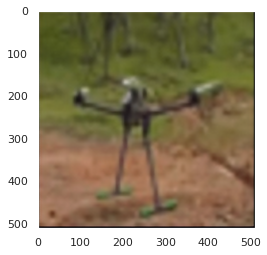

In [56]:
plt.grid(b=None)
plt.imshow(display_transform()(sr_eval.cpu().squeeze(0)).permute(1, 2, 0))

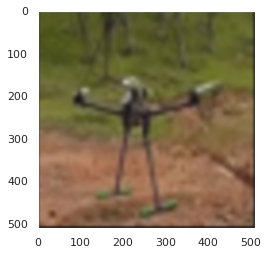

In [57]:
plt.grid(b=None)
plt.imshow(display_transform()(lr_eval.squeeze(0)).permute(1, 2, 0))